This is a script I wrote so that I could better track my students. I found that it was hard to notice slight changes in a student's scores until they had dropped signficiantly. To make sure that I was able to detect more subtle trends, I wanted to flag students who were trending down, underperforming compared to the class, or underperforming compared to themselves.

Current issues:
*   XLSX parsing not working in Google Colab






In [1]:
#from google.colab import files #this is just for google colab
#import io #this is just for google colab
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
# Upload gradebook as CSV file to Google Colab
#uploaded = files.upload() #this is just for google colab
#uploaded #this is just for google colab

The following cell contains arguments which should be set to control output. Select which class period the gradebook corresponds to and which outputs/flags to perform.

In [3]:
filename= "Sample_scoresheet.csv"
# Select which class this gradebook is for
period = "other"   # "Alg", "Pre-alg"

# Set a way to find max scores. This is necessary because our gradebook program only exports
# raw scores, not percentages, and does not include how many points each assignment was out of.
if period == "Alg":
# For algebra, use a dictionary of known max scores
  max_scores_dict = {"Test 1": 20, "Test 2": 20, "Test 3": 20, "Test 4": 20, "Test 5": 20,  
                  "Test 7": 20, "Test 8": 20, "Test 10": 20, "Test 11": 20, "Test 12": 20, 
                   "Test 13": 22, "Test 15": 25, "Common": 25, "Native": 15,  "Native 2": 15}
elif period == "Pre-alg":
  # There is a "facts" test each week which is less important. May want to exclude.
  exclude_facts = True

else:
  # For other classes, just assume the highest score was 100%
  normalize_by_max=True

# This will print lines fit to the scores and flag students who have a >threshold decline
flag_downward_trend = True
trend_threshold = 0.005

# This will find Z scores of the latest score compared to each student's older assignments
# and flag students who underperformed
flag_below_own_average = True
# Select threshold for how many stds below usual score to flag
Z_threshold = 1

# This wll flag students who are underperforming compared to the rest of the class
flag_below_class_average = True
# Select threshold for how many stds below class average to flag
below_class_threshold = 0.5



In [4]:
#filename = list(uploaded.keys())[0] #this is just for google colab

if filename[-4:] == ".csv":
  df=pd.read_csv(filename, index_col=0)

elif filename[-4:] == "xlsx":
  df = pd.read_excel(filename)
  # this is currently not working correctly in Google Colab
  #if extra sheets, may need to use these lines:
  #xl = pd.read_excel(filename)
  #df = xl.parse(0)

# The first column is the overall grade, not a score, so drop it
df.drop(df.columns[[0]], axis=1, inplace=True)

if period == "Alg":
  n_tests = len(max_scores_dict)
  if n_tests!=len(df.columns):
    print("N tests: {}; len columns: {}".format(n_tests, len(df.columns)))
    raise ValueError("the number of assignments in your spreadsheet is not the same as your max_scores list")
  # Turn raw scores into fraction of max
  for col in df.columns:
    df[col] = df[col]/max_scores_dict[col]
  # Average the Common and Native precomp scores together and drop individual scores.
  df["Precomp"] = (df.Common+df.Native)/2
  df.drop(["Common", "Native", "Native 2"], axis=1, inplace=True)

# Since my Pre-alg class has more predictable max scores, use assignment name to get max score.
elif period == "Pre-alg":
  for col in df.columns:
  # Turn raw scores into fraction of max
    if "facts" in col.lower():
      if exclude_facts:
        df.drop(col, axis=1, inplace=True)
      else:
        df[col]=df[col]/10.0
    else:
      df[col]=df[col]/20.0
      
elif normalize_by_max:
  for col in df.columns:
  # Turn raw scores into fraction of max seen
    df[col] = df[col]/df[col].max()
  

n_tests = len(df.columns)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


A student: -0.0052631578947368455


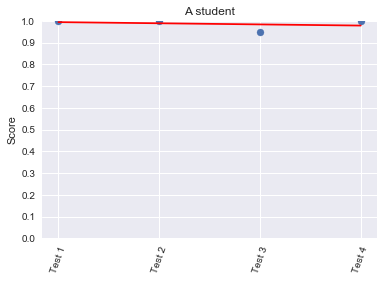

B student: 0.004473684210526328


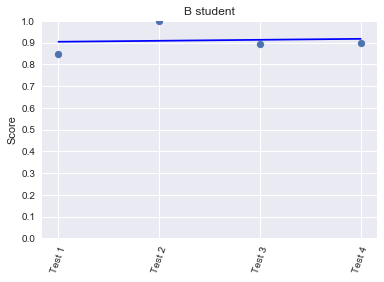

C student: 0.010526315789473687


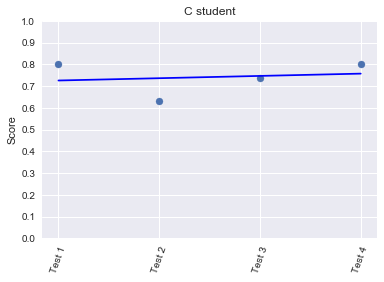

D student: 0.03894736842105261


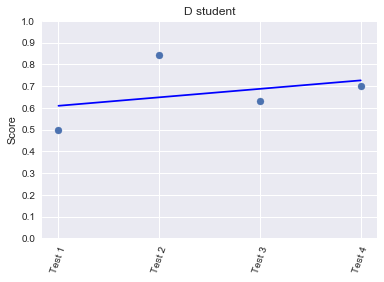

Student with missing assignments: missing scores
Student with missing assignments: -0.05263157894736846


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


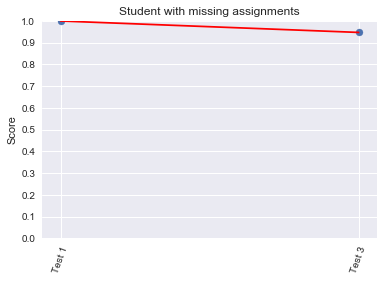

Student trending down: -0.05026315789473681


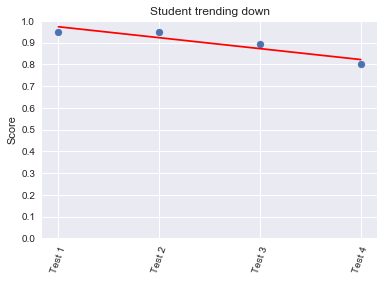

Student with bad recent assignment: -0.054736842105263125


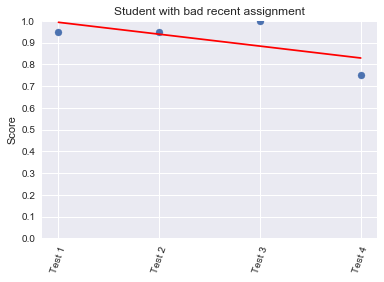

Student trending up: 0.05026315789473686


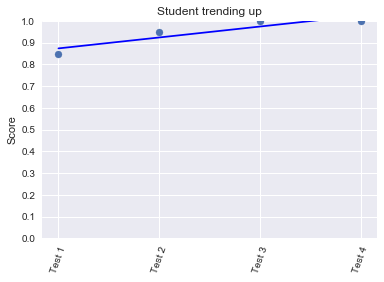

Flagging:  ['A student', 'Student with missing assignments', 'Student trending down', 'Student with bad recent assignment']


In [5]:
def trends(df, flag_students=[]):
  '''Input: pandas dataframe, optional list of students who are flagged. 
  Output: list of students flagged because they are trending down more steeply
  than the accepted threshold'''
  for student, scores in df.iterrows():
        try:
            regressor = LinearRegression() #initialize
            X = np.arange(n_tests).reshape(-1, 1)
            y = scores.reshape(-1, 1)
            regressor.fit(X, y)
        except:
            print(student+": missing scores")
            scores = scores.dropna()
            y = scores.reshape(-1,1)
            X = np.arange(len(y)).reshape(-1, 1)
            regressor.fit(X, y)
        trend = regressor.coef_[0][0]
        print(student+ ": {}".format(trend))
        predict = regressor.predict(X)
        if trend < -trend_threshold:
            flag_students.append(student)
            color = "red"
        else:
            color = "blue"
        plt.scatter(X, y)
        plt.plot(X, predict, color=color)
        plt.xticks(X, scores.index, rotation = 70)
        plt.yticks(np.arange(0,1.1,0.1))
        plt.ylim([0,1])
        plt.ylabel("Score")
        plt.title(student)
        #plt.margins(0.02)
        plt.show()
        
  print("Flagging: ", flag_students)
  return set(flag_students)
    
if flag_downward_trend:
    flag_downward_trend_students=trends(df)

In [6]:
def below_own_avg(df, flag_students = []):
  '''Input: pandas dataframe, optional list of students who are flagged
   Output: list of students flagged because they performed worse than normal'''
  print("Latest assignment:", df.columns[-1])
  for student, scores in df.iterrows():
      try:
          avg = scores[:-1].mean()
          std = scores[:-1].std()
          Z = (scores[-1] - avg)/std
          if Z<-Z_threshold:
              print(student+ ": \n{:.2f}, Average: {:.2f} +/-{:.2f}, Latest Test: {:.2f}".format(Z, avg, std, scores[-1]))
              flag_students.append(student)
      except:
          print(student+": error")

  print("Flagging: ", flag_students)
  return set(flag_students)
    
if flag_below_own_average:
    flag_below_own_average_students=below_own_avg(df)

Latest assignment: Test 4
Student trending down: 
-4.19, Average: 0.93 +/-0.03, Latest Test: 0.80
Student with bad recent assignment: 
-7.28, Average: 0.97 +/-0.03, Latest Test: 0.75
Flagging:  ['Student trending down', 'Student with bad recent assignment']


In [7]:
def below_class_avg(df, flag_students = []):
  '''Input: pandas dataframe, optional list of students who are flagged
  Output: list of students flagged because they performed worse than the rest of the class'''
  try:
    last_test = df.iloc[:, -1]
    avg = last_test.mean()
    std = last_test.std()
    Z = (last_test-avg)/std
    flag = Z[Z<-below_class_threshold].sort_values()
    print("Flagging:")
    print(flag)
    flag_students = flag.index.tolist()
    return set(flag_students)
  except:
    print("error")

if flag_below_class_average:
  flag_below_class_average_students = below_class_avg(df, flag_students = []) 

Flagging:
D student                            -1.260252
Student with bad recent assignment   -0.840168
Name: Test 4, dtype: float64


In [8]:
# Test if any students were flagged in all three metrics. They might need intervention
triple_flag = flag_downward_trend_students.intersection(flag_below_own_average_students).intersection(flag_below_class_average_students)
print("Triple flagged: ", triple_flag)


Triple flagged:  {'Student with bad recent assignment'}
